In [1]:
import gradio as gr
import matplotlib.pyplot as plt

from c_interop import Library
from common import Item
from skyline import skyline_decode
from ortools_models import task_one_model_adapter
from data_analys.data_generator import guillotine_cutting, guillotine_cutting_max
from data_analys.draw_utils import draw_cutting, draw_items_cnt, draw_side_bar

from algorithm_wrappers import concat_placement

Running locally at: http://127.0.0.1:7860/
To create a public link, set `share=True` in `launch()`.
Interface loading below...


<ipython-input-2-a3e3491c91a7>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


KeyboardInterrupt: 

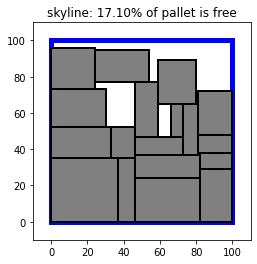

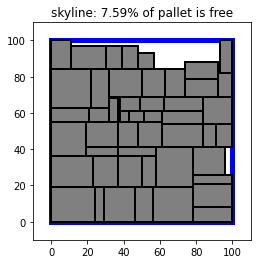

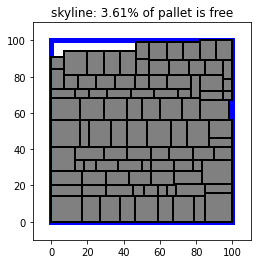

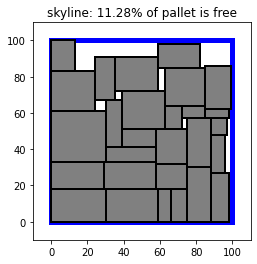

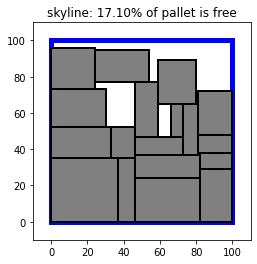

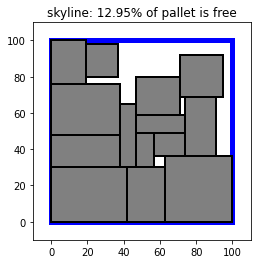

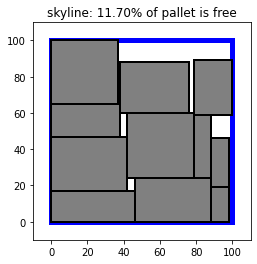

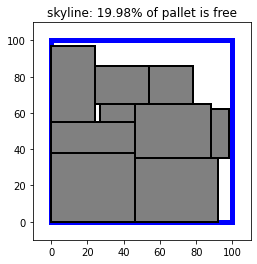

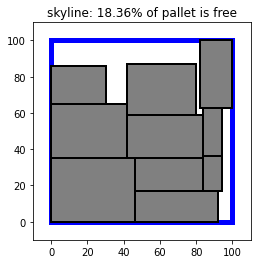

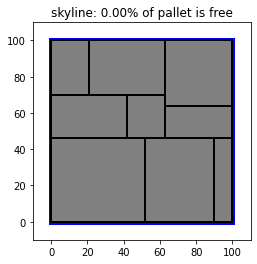

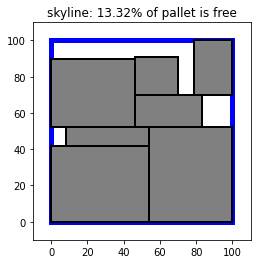

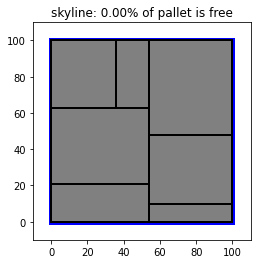

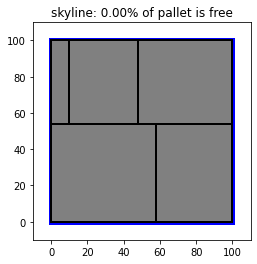

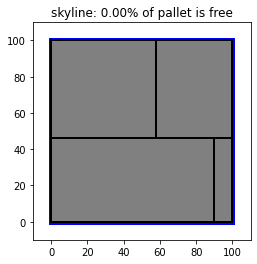

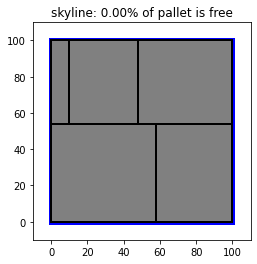

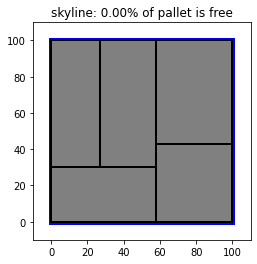

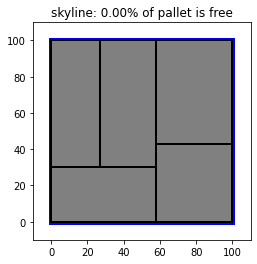

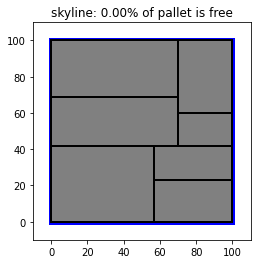

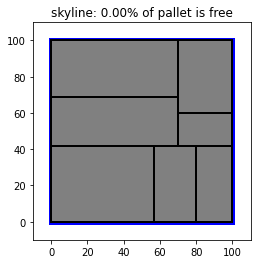

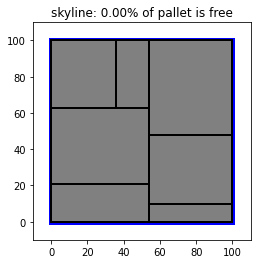

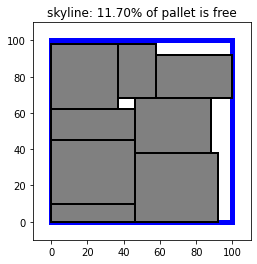

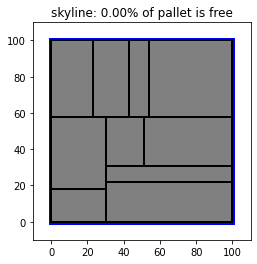

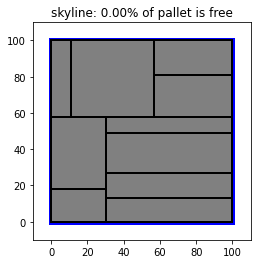

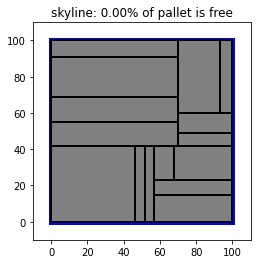

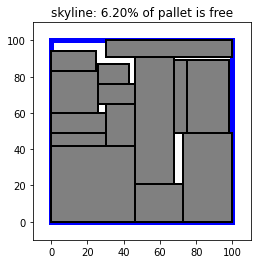

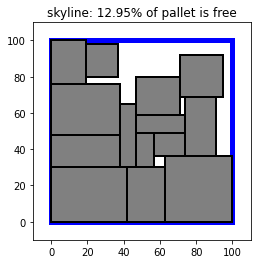

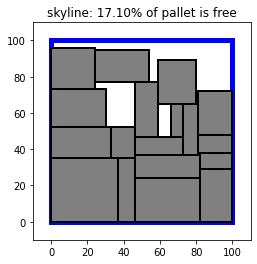

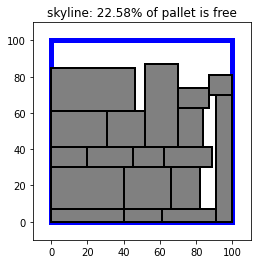

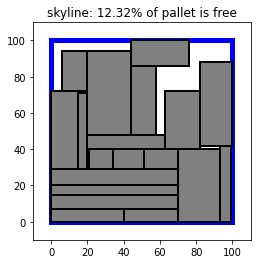

In [2]:
#lib = Library('../lib/libcpp.dll')

algorithm_names = ['skyline','concat']
algorithms = {'skyline': skyline_decode,
              'concat' : concat_placement,
              #'annealing': lib.get_function('simulated_annealing_skyline_auto'),
              'solver': task_one_model_adapter}

def demo_draw(W=100, H=100, num_rect=20, min_side=5, gen_type="max", random_seed=0):
    if "max" == gen_type:
        items_xywh = guillotine_cutting_max(W, H, num_rect, min_side, random_seed)
    elif "rand1" == gen_type:
        items_xywh = guillotine_cutting(W, H, num_rect, min_side, "", random_seed)
    else:
        items_xywh = guillotine_cutting(W, H, num_rect, min_side, "equal", random_seed)

    items_wh = [(w, h) if w > h else (h, w)
                for x, y, w, h in items_xywh
                ]
    items_cl = [Item(int(w), int(h)) for w, h in items_wh]

    figs = []
    for algorithm in algorithm_names:
        fig, ax = plt.subplots()
        figs.append(fig)

        result,positions = algorithms[algorithm](int(W), int(H), items_cl)
        positions_xywh = [(
                pos.x,
                pos.y,
                it.width if not pos.rotated else it.height,
                it.height if not pos.rotated else it.width
                ) for it, pos in zip(items_cl, positions) if pos is not None]
        draw_cutting(H, W, positions_xywh, ax=ax)
        ax.set_title(f'{algorithm}: {result/(W*H):.2%} of pallet is free')
    
    plt.close()
    
    return figs

outputs = [
    gr.outputs.Image(type="plot", label=algorithm)
    for algorithm in algorithm_names
]

iface = gr.Interface(fn=demo_draw,
                     inputs=[
                             gr.inputs.Number(default=100, label="Pallet Width"),
                             gr.inputs.Number(default=100, label="Pallet Height"),
                             gr.inputs.Number(default=20, label="Number of rectangles"),
                             gr.inputs.Number(default=5, label="Minimum side length"),
                             gr.inputs.Radio(["max", "rand1", "rand2"], default="max", label="Generator type"),
                             gr.inputs.Number(default=0, label="Random seed"),
                             ],
                     outputs=outputs,
                     live=False,
                     layout="unaligned",
                     title="Pallet placement demo",
                     verbose=True
                     )

iface.launch(debug = True)